## Import Libraries

In [3]:
# Import standard libraries
import os
import random
import shutil
import pathlib

import pandas as pd
import numpy as np
from collections import defaultdict
import os

# Import PIL for image processing
from PIL import Image

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2

2024-10-05 23:50:24.824630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 23:50:24.839872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 23:50:24.856075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 23:50:24.861136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 23:50:24.875489: I tensorflow/core/platform/cpu_feature_guar

## Data Preparation

In [8]:
dataset_path = 'datasets/hair-type-dataset/data'
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]
print("Subfolders (hair types):", subfolders)

Subfolders (hair types): ['train', 'test']


Shows images and counts of each class in the dataset and the resolution of the images.

In [14]:
# Dictionary to store image counts and resolutions
image_info = {}

# Loop through each subfolder
for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    images_in_subfolder = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Initialize counters for the number of images and resolution frequencies
    num_images = len(images_in_subfolder)
    resolution_count = defaultdict(int)  # Default dictionary to count occurrences of each resolution

    # Process each image
    for image_file in images_in_subfolder:
        image_path = os.path.join(folder_path, image_file)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                resolution_count[(width, height)] += 1  # Increment the count for this resolution
        except Exception as e:
            print(f"Error opening image {image_file}: {e}")

    # Store count of images and their resolution frequencies
    image_info[subfolder] = {
        "num_images": num_images,
        "resolution_count": dict(resolution_count)  # Convert defaultdict to a regular dictionary
    }

In [15]:
# Create a dataframe to organize the results
rows = []
for subfolder, info in image_info.items():
    for resolution, count in info['resolution_count'].items():
        rows.append({
            'Hair Type': subfolder,
            'Resolution': f"{resolution[0]}x{resolution[1]}",
            'Image Count': count
        })

df = pd.DataFrame(rows)

# Display the dataframe
df

,Hair Type,Resolution,Image Count
0,curly,474x711,21
1,curly,460x737,1
2,curly,474x681,1
3,curly,474x609,3
4,curly,474x710,5
...,...,...,...
1238,Straight,564x834,1
1239,Straight,1200x1281,1
1240,Straight,325x363,1
1241,Straight,263x191,1


## Data Preprocessing

In [20]:
img_height, img_width = 150, 150  
batch_size = 32
epochs = 20

In [4]:
def split_dataset(base_path, train_ratio=0.8):
    # Path untuk dataset pelatihan dan pengujian
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    # Membuat folder train dan test jika belum ada
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for root, dirs, files in os.walk(base_path):
        if root == base_path:
            continue

        class_name = os.path.basename(root)
        if class_name in ['train', 'test']:
            continue

        # Membuat folder kelas di dalam train dan test
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Shuffle files
        random.shuffle(files)
        split_index = int(train_ratio * len(files))
        train_files = files[:split_index]
        test_files = files[split_index:]

        # Memindahkan file ke folder train
        for file in train_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(train_class_path, file)
            shutil.move(src_file, dst_file)

        # Memindahkan file ke folder test
        for file in test_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(test_class_path, file)
            shutil.move(src_file, dst_file)


split_dataset(dataset_path)

In [7]:
def delete_unwanted_folders(base_path, keep_folders=['train', 'test']):
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")


delete_unwanted_folders(dataset_path)

Menghapus folder: datasets/hair-type-dataset/data/curly
Menghapus folder: datasets/hair-type-dataset/data/kinky
Menghapus folder: datasets/hair-type-dataset/data/dreadlocks
Menghapus folder: datasets/hair-type-dataset/data/Wavy
Menghapus folder: datasets/hair-type-dataset/data/Straight


## Modelling


In [40]:
def augment_and_resize_dataset(base_path, img_size=(150, 150), batch_size=32):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Hanya rescale untuk data test
    test_datagen = ImageDataGenerator(rescale=1./255)


    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = test_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator ,test_generator

train_generator, validation_generator ,test_generatorm  = augment_and_resize_dataset(dataset_path)

Found 1905 images belonging to 5 classes.
Found 1905 images belonging to 5 classes.
Found 82 images belonging to 5 classes.


In [41]:
class_indices = train_generator.class_indices
print(class_indices)

{'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}


In [33]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))

pre_trained_model.trainable = False

model = Sequential()

model.add(pre_trained_model)

# Menambahkan Conv2D and Pooling layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

/tmp/ipykernel_19347/1046373856.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))


In [35]:
# Compile model
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, restore_best_weights=True, mode='max', baseline=0.96)

In [37]:
History = model.fit(train_generator,
              epochs=epochs,
              validation_data=test_generator,
            #   callbacks=[checkpoint, early_stopping],
              verbose=1)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.5356 - loss: 1.2508 - val_accuracy: 0.7439 - val_loss: 0.5955
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.7828 - loss: 0.5690 - val_accuracy: 0.8049 - val_loss: 0.5402
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.7967 - loss: 0.5500 - val_accuracy: 0.8171 - val_loss: 0.4164
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.8336 - loss: 0.4346 - val_accuracy: 0.7805 - val_loss: 0.5594
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.8552 - loss: 0.3811 - val_accuracy: 0.8049 - val_loss: 0.4804
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.8650 - loss: 0.3364 - val_accuracy: 0.7927 - val_loss: 0.3914
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.8613 - loss: 0.3516 - val_accuracy: 0.8049 - val_loss: 0.4191
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9038 - loss: 0.2807 - val_accuracy

In [42]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

/home/nbs/Documents/Private Iqbal/hair-type-classification/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9476 - loss: 0.1307
Validation Accuracy: 95.43%


## Evaluation

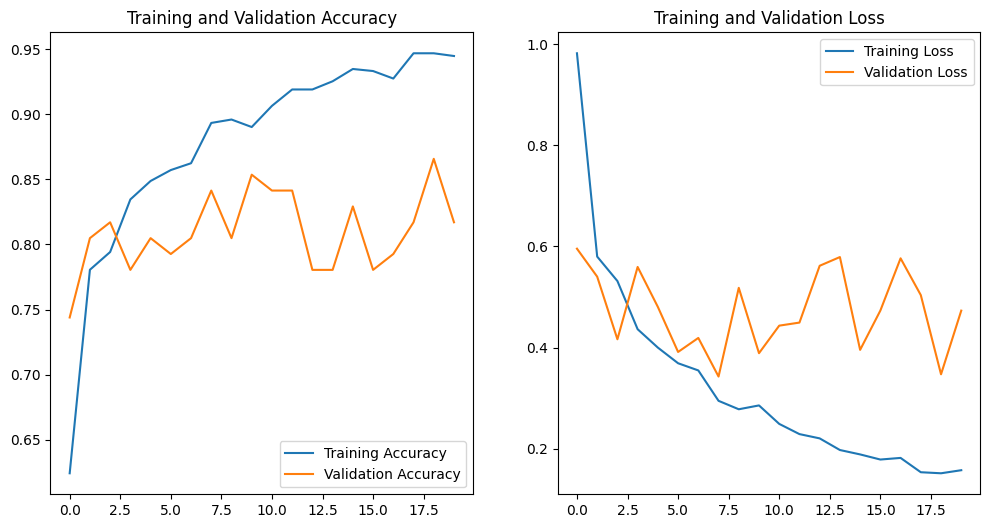

In [43]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Model Conversion

In [51]:
try:
    os.mkdir("models")
    print("Directory 'models' created.")
except FileExistsError:
    print("Directory 'models' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'models' already exists.


In [52]:
model.save("models/model.h5")

In [54]:
!tensorflowjs_converter --input_format=keras models/model.h5 models/tfjs_model

2024-10-06 00:21:55.557188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 00:21:55.565891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 00:21:55.576834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 00:21:55.580291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 00:21:55.588414: I tensorflow/core/platform/cpu_feature_guar

In [55]:
save_path = os.path.join("models/saved_model/")
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: models/saved_model/assets


INFO:tensorflow:Assets written to: models/saved_model/assets


In [56]:
# Load the Keras model
model_TFLITE = tf.keras.models.load_model('models/model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Save the converted model to a file
with open("models/converted_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpoc0qb6x0/assets


INFO:tensorflow:Assets written to: /tmp/tmpoc0qb6x0/assets


Saved artifact at '/tmp/tmpoc0qb6x0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  126171513262496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513168464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513168640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513263024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513265664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513170928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513213344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513214224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513171104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126171513212992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1261715132165

W0000 00:00:1728148994.183330   19347 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1728148994.183350   19347 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-06 00:23:14.183760: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpoc0qb6x0
2024-10-06 00:23:14.191849: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-06 00:23:14.191875: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpoc0qb6x0
2024-10-06 00:23:14.258469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-06 00:23:14.271212: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-06 00:23:14.793273: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpoc0qb6x0
2024-10-06 00:23:14.916242: I tensorflow/cc/saved_model/loader.cc

## Inference

In [57]:
import tensorflow as tf
import requests
import os

In [64]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="models/converted_model.tflite")
interpreter.allocate_tensors()

# Function for image preprocessing (single image)
def image_preprocessing(filename):
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
    image = tf.image.resize(image, [150, 150])
    image = image / 255.0  # Normalize image
    image_tensor = tf.expand_dims(image, 0)  # Add batch dimension
    return image_tensor

# List of filenames to be processed
filenames = [
    os.path.join('images', 'curly.jpg'),
    os.path.join('images', 'straight.jpg'),
    os.path.join('images', 'wavy.jpg'),
    os.path.join('images', 'kinky.jpeg'),
    os.path.join('images', 'dreadlocks.jpg')
]

# Get input and output details for TFLite interpreter
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Map the predicted classes to labels
map_labels = {0: 'Straight', 1: 'Wavy', 2: 'Curly', 3: 'Dreadlocks', 4: 'Kinky'}

# Loop through each image, preprocess, and run inference
for filename in filenames:
    image_tensor = image_preprocessing(filename)

    # Set the input tensor with the preprocessed image data
    interpreter.set_tensor(input_details[0]['index'], image_tensor.numpy())

    # Run inference
    interpreter.invoke()

    # Get the prediction from the output tensor
    prediction = interpreter.get_tensor(output_details[0]['index'])

    # Find the class with the highest probability
    predicted_class = np.argmax(prediction)
    print(f"Image: {filename}, Predicted class: {map_labels[predicted_class]}")

Image: images/curly.jpg, Predicted class: Curly
Image: images/straight.jpg, Predicted class: Straight
Image: images/wavy.jpg, Predicted class: Wavy
Image: images/kinky.jpeg, Predicted class: Straight
Image: images/dreadlocks.jpg, Predicted class: Dreadlocks
